In [1]:
from torchmetrics import Dice

/home/user0/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
from pathlib import Path

import numpy as np
from pytorch_lightning import LightningDataModule, Trainer, LightningModule


from tqdm import tqdm
from dataset.patch_dataset import BrainPatchesDataModule
from models.UNetModule import UNet3
from dataset.roi_extraction import slice_image, reconstruct_patches
from utils import z_score_norm
import SimpleITK as sitk
import torch
from models.EM import ExpectationMaximization
import cv2
import matplotlib.pyplot as plt
cfg = {'pl_trainer':{'max_epochs': 20,
                     'devices': [2],
                     'accelerator': 'gpu'},
       
       'dataset':{'window_size': 64,
                  'stride': 32,
                  'img_threshold': 0.6,
                  'normalization': 'z_score'},
       
       'train_num_workers':8,
       'train_batch_size': 64,
       'val_num_workers':8,
       'val_batch_size': 64}

device = torch.device('cuda:2')
class BrainSegmenter:
    def __init__(self, model_checkpoint_path: Path,
                 cfg: dict):
        super().__init__()
        self.cfg = cfg
        self.model = UNet3.load_from_checkpoint(model_checkpoint_path,
                                                n_classes=4,
                                                in_channels=1,
                                                feature_scale=4,
                                                loss='cross_entropy',
                                                model='UNet_3Plus').to(device)

        # disable randomness, dropout, etc...
        self.model.eval()


    def segment(self, image: np.ndarray,
                mask):
        
        segm_reconstructed = np.zeros_like(image)
        
        for slice in tqdm(range(image.shape[0])):
            if slice <100:
                continue
            
            image_slices = slice_image(image[slice, :, :],
                                       self.cfg['dataset']['window_size'],
                                       self.cfg['dataset']['stride'])
            
            mask_slices = slice_image(mask[slice, :, :],
                                      self.cfg['dataset']['window_size'],
                                      self.cfg['dataset']['stride'])
            
            empty_slices_mask = np.asarray([s.sum()==0 for s in image_slices])
                        
            # CHANGE IF CHANGE NORMALIZATION OR ADD ANOTHER CHANNEL
            image_slices = [z_score_norm(slice, non_zero_region=True) for slice in image_slices]
            image_slices = np.expand_dims(np.asarray(image_slices, dtype=np.float32), axis=1)
            image_slices = torch.tensor(image_slices, requires_grad=False).to(device)
            
            # predict with the model
            y_hat = self.model(image_slices).detach().cpu().numpy()
            y_hat = np.argmax(y_hat, axis=1)
            return y_hat, mask_slices, image_slices.detach().cpu().numpy()
            segm_reconstructed[slice, :, :] = reconstruct_patches(y_hat,
                              image[slice, :, :],
                              cfg['dataset']['window_size'],
                              cfg['dataset']['stride'])
            
        # print(y_hat.shape, image_slices.shape, segm_reconstructed.shape)
        return segm_reconstructed

chk = '/home/user0/misa_vlex/brain_segmentation/outputs/init_run/version_3/checkpoints/epoch=13-valid_dsc=0.9522.ckpt'
brsm = BrainSegmenter(chk, cfg)
img = sitk.ReadImage('/home/user0/misa_vlex/brain_segmentation/data/Validation_Set/IBSR_11/IBSR_11.nii.gz')
segm = sitk.ReadImage('/home/user0/misa_vlex/brain_segmentation/data/Validation_Set/IBSR_11/IBSR_11_seg.nii.gz')

em = ExpectationMaximization(3)

In [21]:
pred_slices, mask_slices, slices = brsm.segment(sitk.GetArrayFromImage(img),
                         sitk.GetArrayFromImage(segm))

  0%|          | 0/256 [00:00<?, ?it/s]/home/user0/misa_vlex/brain_segmentation/utils.py:7: RuntimeWarning: Mean of empty slice.
  mean = img[img != 0].mean()
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 39%|███▉      | 100/256 [00:00<00:00, 572.38it/s]


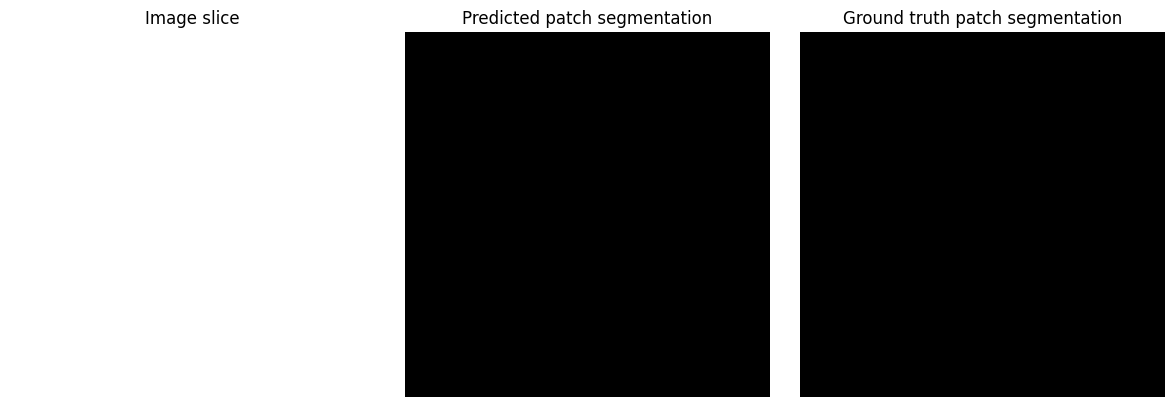

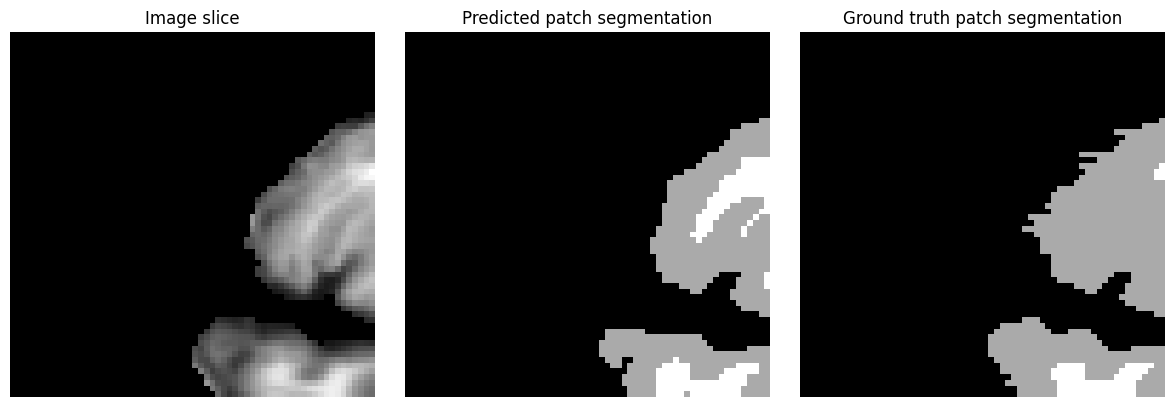

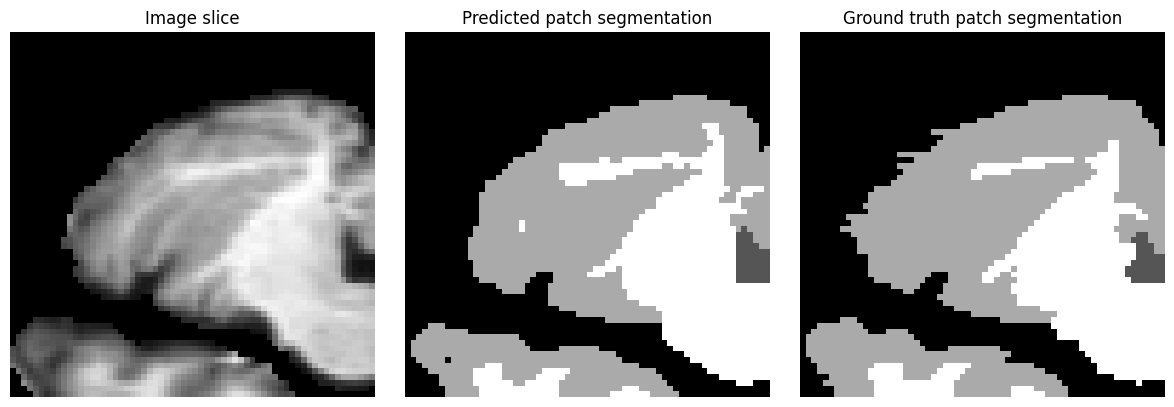

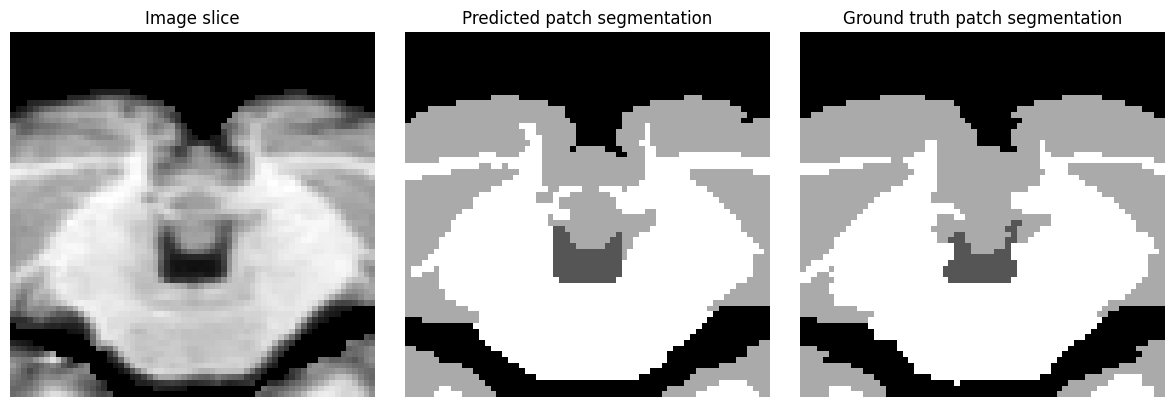

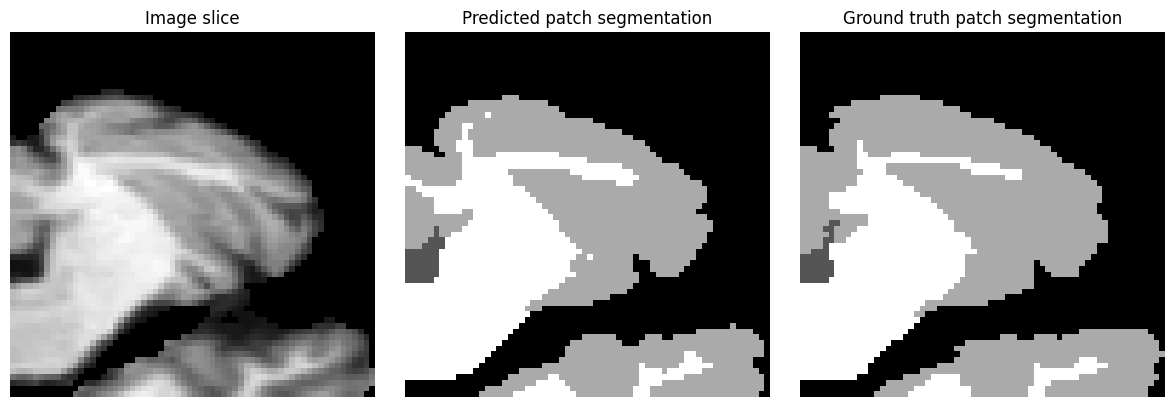

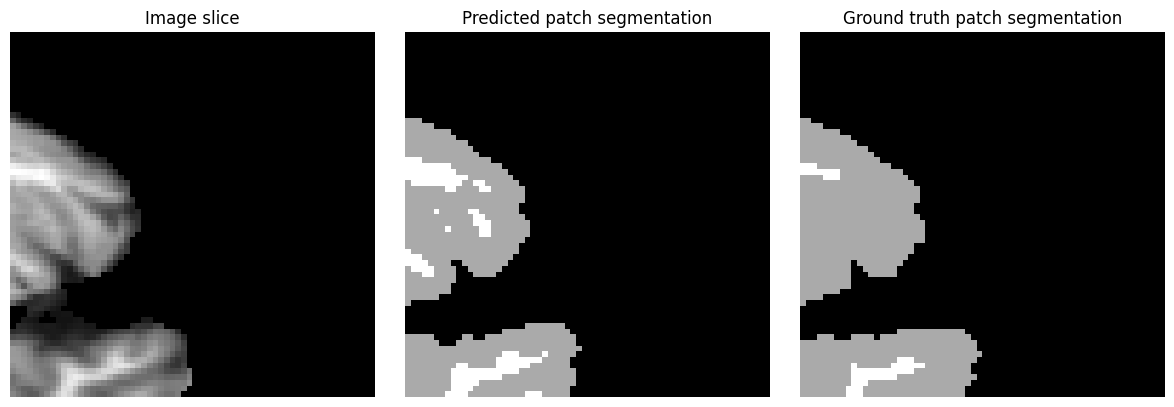

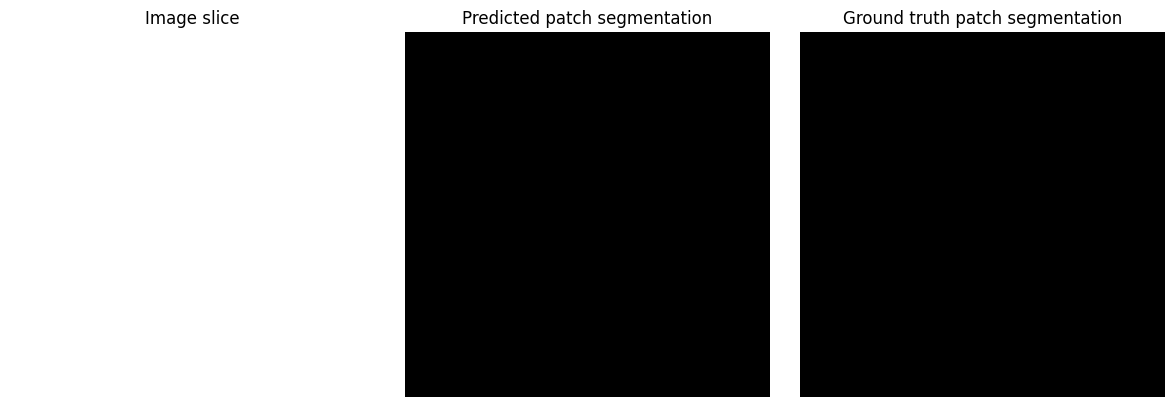

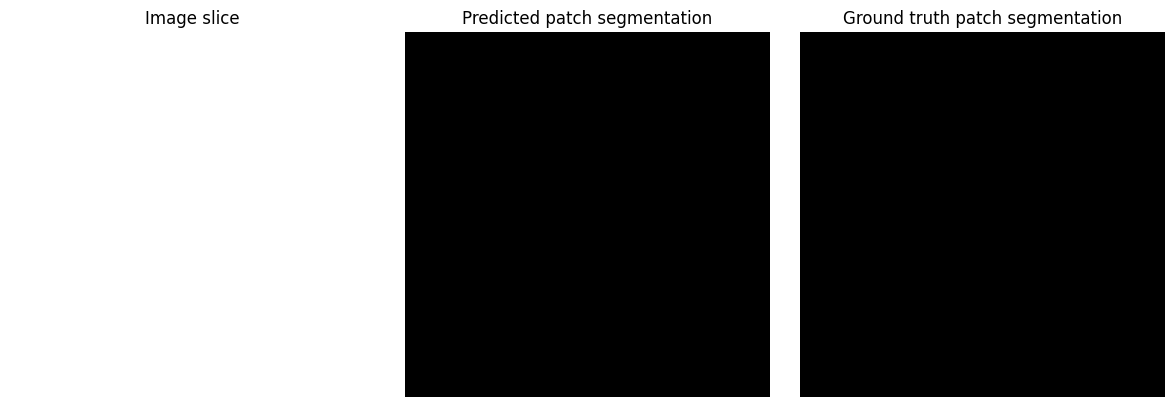

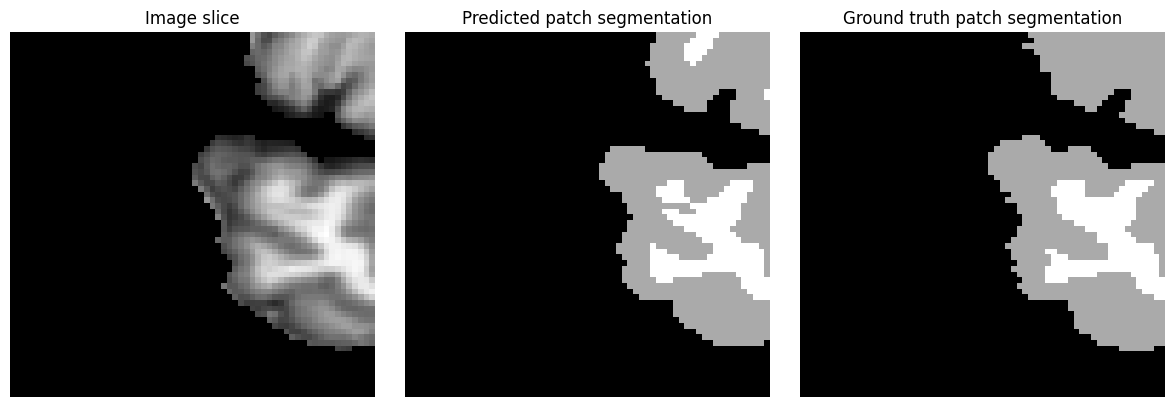

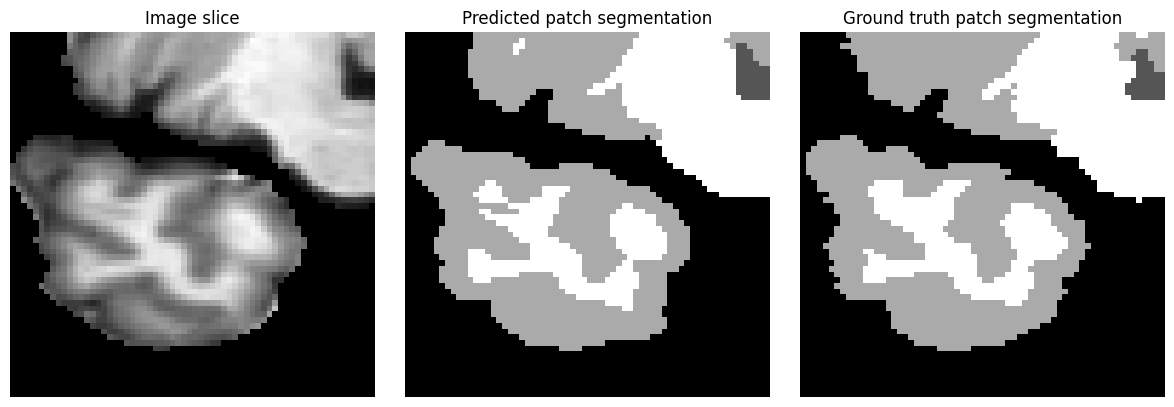

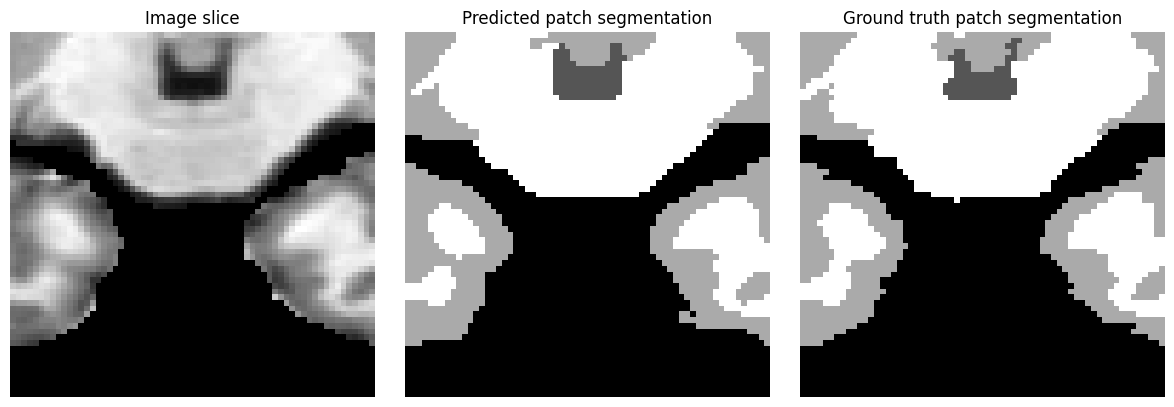

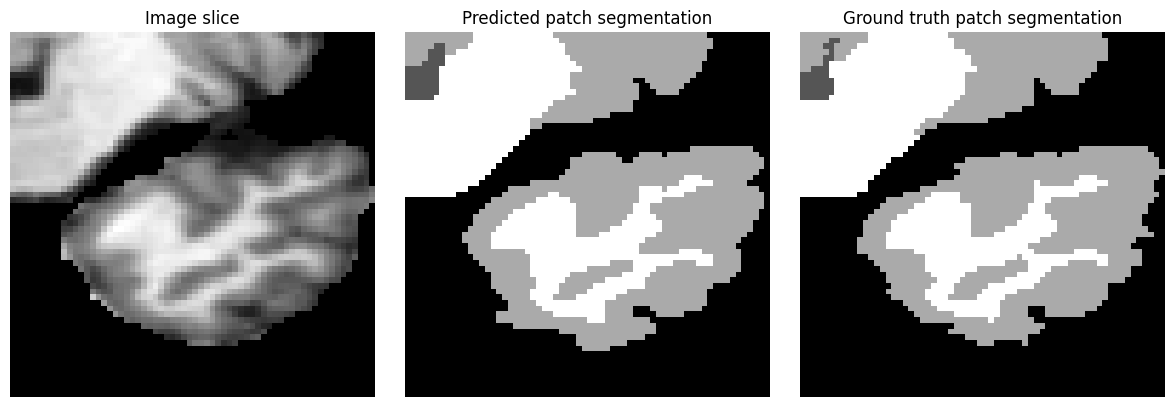

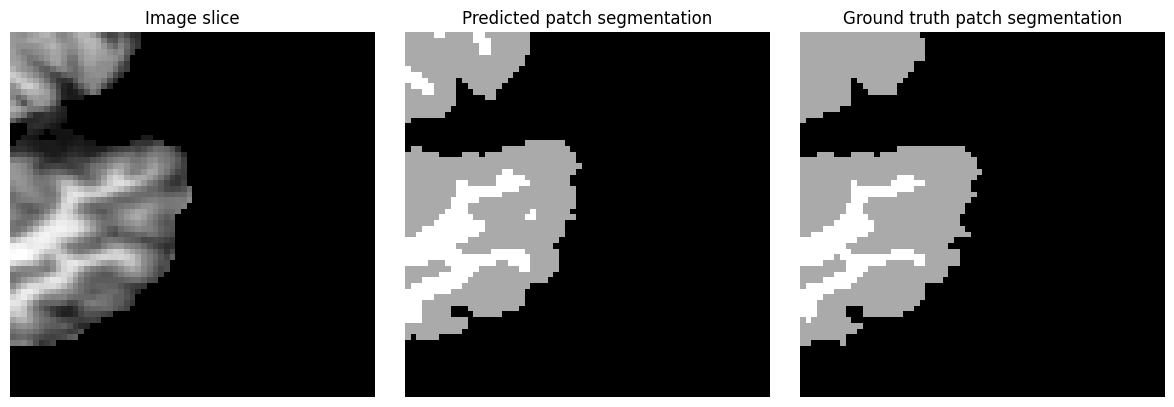

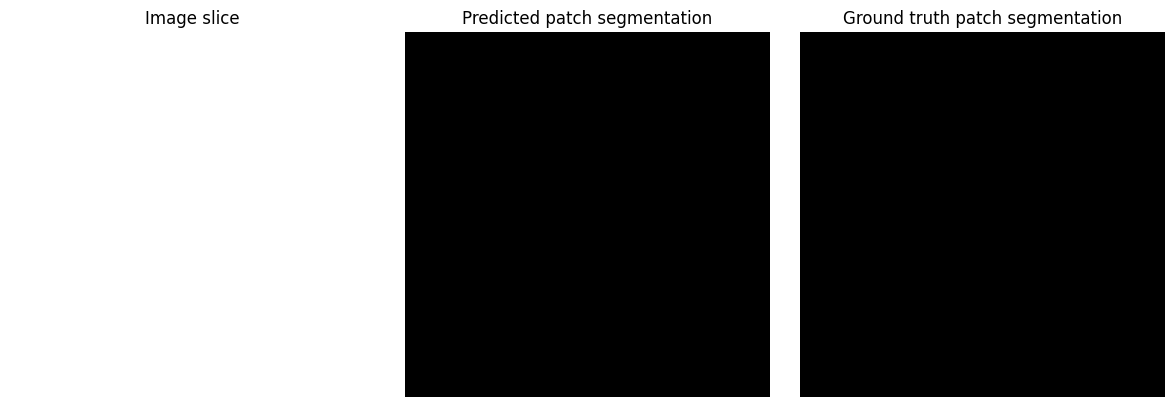

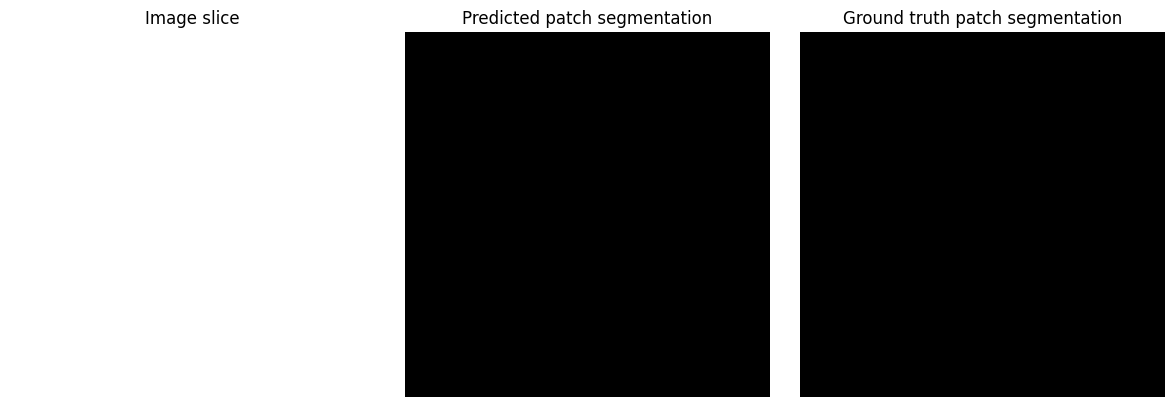

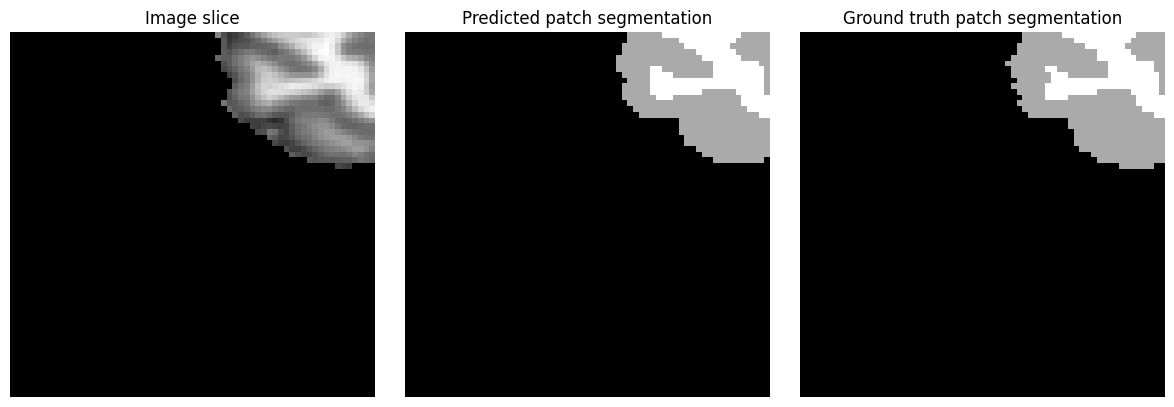

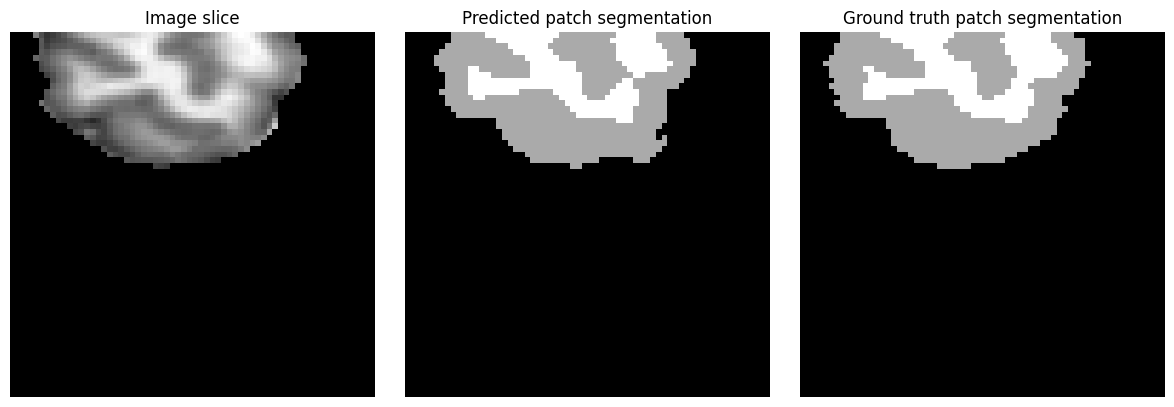

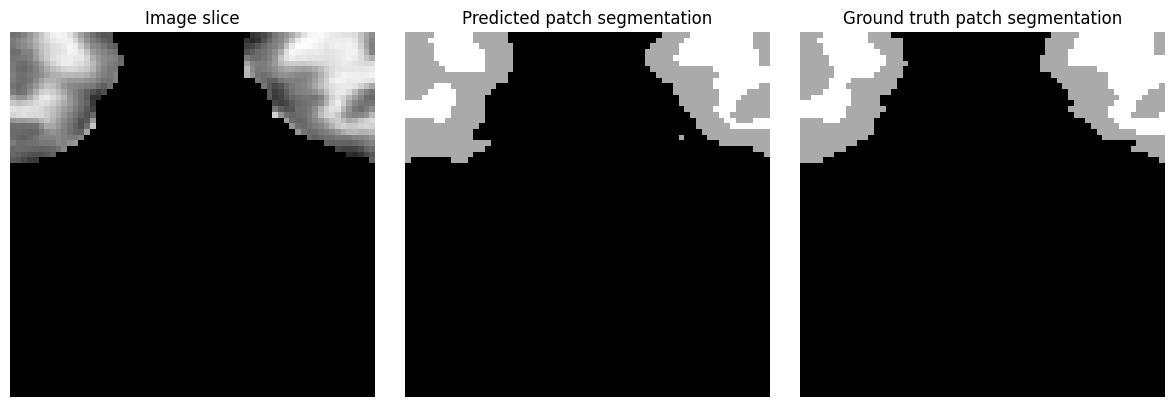

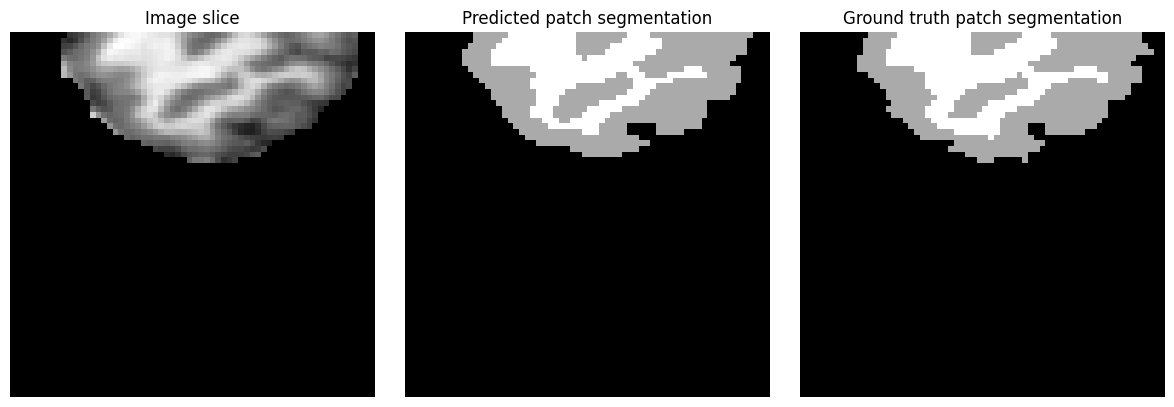

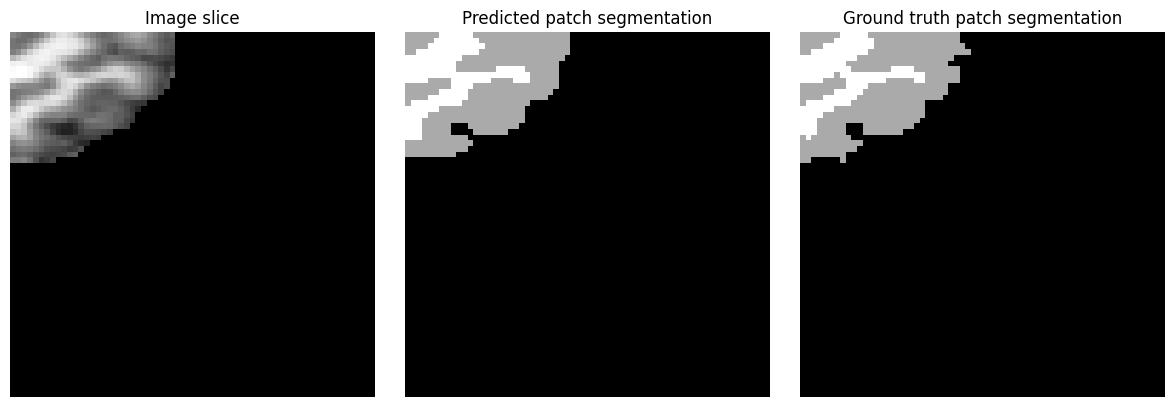

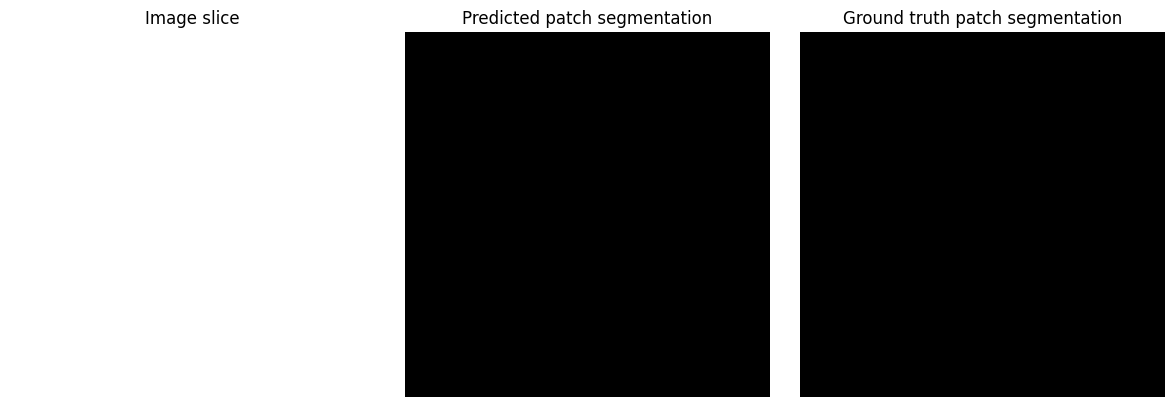

In [22]:
for s in range(len(pred_slices)):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    # plt.title(f'DSC: {d(torch.Tensor(pred_slices[s, :, :]).unsqueeze(0), torch.tensor(mask_slices[s, :, :]).unsqueeze(0).int())}')
    ax[0].imshow(slices[s, 0, :, :], cmap='gray')
    ax[1].imshow(pred_slices[s, :, :], cmap='gray')
    ax[2].imshow(mask_slices[s, :, :], cmap='gray')
    ax[0].set_title('Image slice')
    ax[0].set_axis_off()
    ax[1].set_title('Predicted patch segmentation')
    ax[1].set_axis_off()
    ax[2].set_title('Ground truth patch segmentation')
    ax[2].set_axis_off()
    plt.tight_layout()
    plt.show()

In [1]:
from brain_segmenter import BrainSegmenter
from pathlib import Path

from pathlib import Path

import numpy as np
from pytorch_lightning import LightningDataModule, Trainer, LightningModule


from tqdm import tqdm
from dataset.patch_dataset import BrainPatchesDataModule
from models.UNetModule import UNet3
from dataset.roi_extraction import slice_image, reconstruct_patches
from utils import z_score_norm
import SimpleITK as sitk
import torch
from models.EM import ExpectationMaximization
import cv2
import matplotlib.pyplot as plt

/home/user0/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chk = Path('/home/user0/misa_vlex/brain_segmentation/outputs/init_run/version_3/checkpoints/epoch=13-valid_dsc=0.9522.ckpt')
brsm = BrainSegmenter(chk, device='cuda:2')
img = sitk.ReadImage('/home/user0/misa_vlex/brain_segmentation/data/Validation_Set/IBSR_11/IBSR_11.nii.gz')
segm = sitk.ReadImage('/home/user0/misa_vlex/brain_segmentation/data/Validation_Set/IBSR_11/IBSR_11_seg.nii.gz')
img_np = sitk.GetArrayFromImage(img)
mask_np = sitk.GetArrayFromImage(segm)
em = ExpectationMaximization(3)
segm_pred = brsm.segment(img_np)

  0%|          | 0/256 [00:00<?, ?it/s]/home/user0/misa_vlex/brain_segmentation/utils.py:7: RuntimeWarning: Mean of empty slice.
  mean = img[img != 0].mean()
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/user0/.local/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 29%|██▉       | 74/256 [00:23<00:29,  6.09it/s]/home/user0/misa_vlex/brain_segmentation/utils.py:15: RuntimeWarning: divide by z

In [3]:
em.compute_dice(mask_np, segm_pred)

{'CSF': 0.8901405784067781, 'WM': 0.9209871939551543, 'GM': 0.937117647460544}

In [3]:
em.compute_dice(mask_np, segm_pred)

{'CSF': 0.8899621212121213, 'WM': 0.9222652280574143, 'GM': 0.9371394073167534}